In [495]:
import plotly.plotly as py
import plotly.graph_objs as go
import json
import plotly
import math
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
plotly.tools.set_credentials_file(username='DDoLgi', api_key='uQWaeY4qf77SG6mMW2vJ')

파일을 열어 모든 line을 스캔

In [496]:
f1 = open('kmk_test_down1_eye_0.txt')
lines = []
lines.append(f1.readlines())
f1.close()

Json 형식을 읽어들임

In [497]:
data = []
for i in range(len(lines)):
    data.append([])
    for j in range(len(lines[i])):
        str = lines[i][j].replace("'", '"')[12:lines[i][j].rfind('}') + 1]
        data[i].append(json.loads(str))
        tintinPivot = lines[i][j].rfind(':')
        data[i][j]['vection'] = float(lines[i][j][tintinPivot+2:-1])

0부터 시작하도록 timestamp를 맞춰줌

In [498]:
for i in range(len(data)):
    initial_timestamp = data[i][0]['timestamp']
    for j in range(len(data[i])):
        data[i][j]['timestamp'] -= initial_timestamp

필요한 정보(position과 timestamp)를 가져온다. 이 때 confidence가 일정량 이하라면, 믿을 수 없는 데이터라 판단, 보간을 실행한다. 노이즈를 제거하기 위한 smoothing도 한다.

In [499]:
timestamp = []
horizontal_pos = []
vertical_pos = []
vection = []
for i in range(len(data)):
    timestamp.append([])
    horizontal_pos.append([])
    vertical_pos.append([])
    vection.append([])
    for j in range(len(data[i])):
        timestamp[i].append(data[i][j]['timestamp'])
        horizontal_pos[i].append(data[i][j]['norm_pos'][1])
        vertical_pos[i].append(data[i][j]['norm_pos'][0])
        vection[i].append(data[i][j]['vection'])
    count = 0
    former_h = 0
    former_v = 0
    latter_h = 0
    latter_v = 0
    
    j = 0
    for j in range(len(data[i])):
        if data[i][j]['confidence'] < 0.7: #어디까지를 믿을만한 데이터로 볼지는 여기서 판단
            if count == 0 and j != 0:
                former_h = horizontal_pos[i][j - 1]
                former_v = vertical_pos[i][j - 1]
            count += 1
            continue
        elif count != 0:
            latter_h = horizontal_pos[i][j]
            latter_v = vertical_pos[i][j]
            for k in range(count):
                horizontal_pos[i][j - k - 1] = former_h + (latter_h - former_h) * (count - k) / (count + 1)
                vertical_pos[i][j - k - 1] = former_v + (latter_v - former_v) * (count - k) / (count + 1)
            former_h = 0
            former_v = 0
            latter_h = 0
            latter_v = 0
            count = 0
    
    horizontal_pos[i] = signal.savgol_filter(horizontal_pos[i], 5, 3)

In [500]:
vection_trace = go.Scatter(
        x=timestamp[0],
        y=vection[0],
        yaxis='y2'
)

In [501]:
horizontal_pos_trace = []
for i in range(len(data)):
    traceName = 'subject' + repr(i)
    horizontal_pos_trace.append(go.Scatter(x=timestamp[i], y=horizontal_pos[i], name=traceName))
    horizontal_pos_trace.append(vection_trace)

## 가로 눈의 움직임-시간 그래프

In [502]:
horizontal_pos_data=go.Data(horizontal_pos_trace)
horizontal_pos_layout=go.Layout(title="Horizontal Position", xaxis={'title':'time'}, yaxis={'title':'position'}, yaxis2=dict(overlaying='y', side='right'))
horizontal_pos_figure=go.Figure(data=horizontal_pos_data,layout=horizontal_pos_layout)
py.iplot(horizontal_pos_figure)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~DDoLgi/0 or inside your plot.ly account where it is named 'plot from API'


비슷한 방식으로 시간-(세로눈위치) 그래프 생성

In [503]:
vertical_pos_trace = []
for i in range(len(data)):
    traceName = 'subject' + repr(i)
    vertical_pos_trace.append(go.Scatter(x=timestamp[i], y=vertical_pos[i], name=traceName))
    vertical_pos_trace.append(vection_trace)

## 세로 눈의 움직임-시간 그래프

In [504]:
vertical_pos_data=go.Data(vertical_pos_trace)
vertical_pos_layout=go.Layout(title="Vertical Position", xaxis={'title':'time'}, yaxis={'title':'position'}, yaxis2=dict(overlaying='y', side='right'))
vertical_pos_figure=go.Figure(data=vertical_pos_data,layout=vertical_pos_layout)
py.iplot(vertical_pos_figure, filename='pyguide_2')

눈을 하나의 unit sphere라고 생각하여, 그 구 표면에 pupil이 있다고 가정하자.<br />
pupil labs에서 주어지는 normpos는 [0,1]까지의 범위를 갖고 있다. 이것을 인용할 논문(A simple pupil-independent method for recording eye movements in rodents using video)이 사용한 범위([-1, 1])로 고쳐내자.<br />
위 논문에 의하면 눈이 중심에 있을 때의 위치와 현재 위치의 차이를 구한 다음 그것을 반지름으로 나누고 있다((Z - Z0)/r).<br />
norm_pos는 0부터 2r까지의 범위를 가질 수 있는 눈의 위치를 2r로 나누어 0~1을 만든 것으로 추정됨.
따라서 norm_pos의 값은 Z/2r, 중심이라 할 수 있는 눈의 위치는 Z0/2r. 그렇다면 중심위치를 가정한다음 norm_pos에서 그것을 빼고, 2를 곱하면 논문에서 쓰였던 벡터의 성분을 구할 수 있을 것이다. Z0의 좌표를 (0.5, 0.5)라 가정한다면 Mz = (norm_pos - 0.5) * 2

In [505]:
angular_vector = []
for i in range(len(data)):
    angular_vector.append([])
    for j in range(len(data[i])):
        angular_vector[i].append([])
        angular_vector[i][j] = [0, (horizontal_pos[i][j] * 2 - 1), (vertical_pos[i][j] * 2 - 1)]
        angular_vector[i][j][0] = math.sqrt(1 - math.pow(angular_vector[i][j][1], 2) - math.pow(angular_vector[i][j][2], 2))

그 후 논문에 따르면, Fick Gimbal에서 Horizontal 회전을 담당하는 세타, Vertical 회전을 담당하는 파이는 각각 이렇게 구할 수 있다.

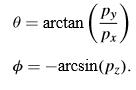

In [506]:
theta = []
phi = []
for i in range(len(data)):
    theta.append([])
    phi.append([])
    for j in range(len(data[i])):
        theta[i].append(math.degrees(np.arctan(angular_vector[i][j][1] / angular_vector[i][j][0])))
        phi[i].append(math.degrees(-1 * np.arcsin(angular_vector[i][j][2])))

In [507]:
theta_trace = []
phi_trace = []
for i in range(len(data)):
    traceName = 'subject' + repr(i)
    theta_trace.append(go.Scatter(x=timestamp[i], y=theta[i], name=traceName))
    phi_trace.append(go.Scatter(x=timestamp[i], y=phi[i], name=traceName))
    theta_trace.append(vection_trace)
    phi_trace.append(vection_trace)

In [508]:
theta_data=go.Data(theta_trace)
theta_layout=go.Layout(title="theta-time", xaxis={'title':'time'}, yaxis={'title':'position'}, yaxis2=dict(overlaying='y', side='right'))
theta_figure=go.Figure(data=theta_data,layout=theta_layout)
phi_data=go.Data(phi_trace)
phi_layout=go.Layout(title="phi-time", xaxis={'title':'time'}, yaxis={'title':'position'}, yaxis2=dict(overlaying='y', side='right'))
phi_figure=go.Figure(data=phi_data,layout=phi_layout)

## theta(가로) 방향 각도 움직임 - 시간 그래프

In [509]:
py.iplot(theta_figure, filename='pyguide_1')

## phi(세로) 방향 각도 움직임 - 시간 그래프

In [510]:
py.iplot(phi_figure, filename='pyguide_1')

이후 각을 시간에 대해 미분하여 각속도를 구한다.

In [511]:
theta_vel = []
theta_vel_trace = []
phi_vel = []
phi_vel_trace = []
for i in range(len(data)):
    theta_vel.append([np.zeros(np.array(theta[i]).shape, np.float)])
    theta_vel[i][0:-1] = np.diff(theta[i])/np.diff(timestamp[i])
    theta_vel[i][-1] = (theta[i][-1] - theta[i][-2])/(timestamp[i][-1] - timestamp[i][-2])
    theta_vel_trace.append(go.Scatter(x=timestamp[i], y=theta_vel[i], name='subject' + repr(i)))
    
    phi_vel.append([np.zeros(np.array(phi[i]).shape, np.float)])
    phi_vel[i][0:-1] = np.diff(phi[i])/np.diff(timestamp[i])
    phi_vel[i][-1] = (phi[i][-1] - phi[i][-2])/(timestamp[i][-1] - timestamp[i][-2])
    phi_vel_trace.append(go.Scatter(x=timestamp[i], y=phi_vel[i], name='subject' + repr(i)))

In [512]:
theta_vel_trace.append(vection_trace)
phi_vel_trace.append(vection_trace)

theta_vel_data=go.Data(theta_vel_trace)
theta_vel_layout=go.Layout(title="theta vel - time", xaxis={'title':'time'}, yaxis={'title':'deg/s'}, yaxis2=dict(overlaying='y', side='right'))
theta_vel_figure=go.Figure(data=theta_vel_data,layout=theta_vel_layout)

phi_vel_data=go.Data(phi_vel_trace)
phi_vel_layout=go.Layout(title="phi vel - time", xaxis={'title':'time'}, yaxis={'title':'deg/s'}, yaxis2=dict(overlaying='y', side='right'))
phi_vel_figure=go.Figure(data=phi_vel_data,layout=phi_vel_layout)

## 세타 각 속도 - 시간 그래프

In [513]:
py.iplot(theta_vel_figure, filename='pyguide_1')

## 파이 각 속도 - 시간 그래프

In [514]:
py.iplot(phi_vel_figure, filename='pyguide_1')